<a href="https://colab.research.google.com/github/lewis-m/yeast-mutation-tda/blob/master/PyStanTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Prerequesite installations
#Run once everytime runtime is restarted

import numpy as np
import cython

!pip install pystan
!pip install Ripser

import pystan as ps
from ripser import ripser
from persim import plot_diagrams, bottleneck

    100% |████████████████████████████████| 81kB 3.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/95/6f/54/972a0889246bc3b1b47d769021bd61bb1d42153cdb58aa7fd3
Successfully built Ripser


In [2]:
#Upload file/data
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving WildType.xlsx to WildType.xlsx
Saving E203K.xlsx to E203K.xlsx
Saving F53S.xlsx to F53S.xlsx
Saving Y130C.xlsx to Y130C.xlsx
Saving FirstData.xlsx to FirstData.xlsx


In [0]:
#Import empirical data
import numpy as np
import pandas as pd

xlsx = pd.ExcelFile('FirstData.xlsx')
df = pd.read_excel(xlsx, 'Wild Type')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

wild_type = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'Y130C')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

y130c = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'F53S')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

f53s = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'E203K')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

e203k = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])


#put all data into one data frame
bayes_td = np.array([wild_type, y130c, f53s, e203k])

In [0]:
#Import bootstrapped data

file_names = ['WildType.xlsx', 'Y130C.xlsx', 'F53S.xlsx', 'E203K.xlsx']
bs_data = []

for file_name in file_names:
  xlsx = pd.ExcelFile(file_name)

  df = pd.read_excel(xlsx, 'Sheet1')
  df = df.iloc[1:(-1), 0:3]

  bs_data.append(df.values)

In [0]:
#Caluculate variances
variance = np.var(bayes_td, axis = 1)

print(variance)

[[[0.407898743208211 0.44202692154055684 0.08872811066551656]
  [0.3482158047554182 0.2346684200252743 0.07985859685628442]
  [0.44241425823285035 0.20837829342483077 0.11903757620745647]
  [0.34025579141089596 0.09476706535235742 0.12930036536600711]
  [0.19981381767885548 0.02593906022502403 0.1449450950999056]
  [0.1488271854748052 0.24476519576693206 0.6979500950176968]
  [0.0436605479212564 0.02505282004636366 0.12271341234043029]]

 [[0.31274399999999997 0.07908000000000001 0.15630400000000003]
  [0.06798399999999998 0.122376 0.06270399999999998]
  [0.09893600000000002 0.162584 0.11512]
  [0.07109599999999999 0.18781600000000007 0.062104000000000006]
  [0.10921600000000001 0.09809599999999999 0.06509600000000001]
  [0.021416 0.033464 0.081344]
  [0.004136 0.0 0.004136000000000006]]

 [[0.5257999999999997 0.24490399999999993 0.17618400000000004]
  [0.08285600000000001 0.01981599999999999 0.088376]
  [0.025383999999999983 0.04598399999999999 0.06521600000000002]
  [0.05219999999999

In [0]:
def stan_model_yd(yeast_data):

  time_stamps = [0.5, 2, 3.25, 3.75, 5, 10, 20]

  yeast_code = """
  data {
      int<lower=0> T; // number of trials
      int<lower=0> TS; // number of timesteps
      vector[TS] ts; // time values
      real S0[TS,T]; // param S0
      real S1[TS,T]; // param S1
      real S2[TS,T]; // param S2
  }
  parameters {
      real P1;
      real P2;
      real Pi;
      real sigma1;
      //real sigma2;
      //real sigma3;
  }

  model {
      P1 ~ uniform(0,10);
      P2 ~ uniform(0,10);
      Pi ~ uniform(0,10);
      
      sigma1 ~ uniform(0,10);
      //sigma2 ~ uniform(0,10);
      //sigma3 ~ uniform(0,10);   

      for(i in 1:TS){
        real s0 = exp(-P1*ts[i]);
        real s1 = P1*(1-Pi)/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i]));
        real s2 = P1*Pi/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i])) + P2/(P1-P2)*(exp(-P1*ts[i]) - 1) + P1/(P1-P2)*(1-exp(-P2*ts[i]));
        
        S0[i, :] ~ normal(s0, sigma1);
        S1[i, :] ~ normal(s1, sigma1);
        S2[i, :] ~ normal(s2, sigma1);
      }
  }
  """

  S0 = np.stack([yeast_data[:, 0, 0], yeast_data[:, 1, 0], yeast_data[:, 2, 0], yeast_data[:, 3, 0], yeast_data[:, 4, 0], yeast_data[:, 5, 0], yeast_data[:, 6, 0]])
  S1 = np.stack([yeast_data[:, 0, 1], yeast_data[:, 1, 1], yeast_data[:, 2, 1], yeast_data[:, 3, 1], yeast_data[:, 4, 1], yeast_data[:, 5, 1], yeast_data[:, 6, 1]])
  S2 = np.stack([yeast_data[:, 0, 2], yeast_data[:, 1, 2], yeast_data[:, 2, 2], yeast_data[:, 3, 2], yeast_data[:, 4, 2], yeast_data[:, 5, 2], yeast_data[:, 6, 2]])

  S0 = np.array(S0, dtype = float)
  S1 = np.array(S1, dtype = float)
  S2 = np.array(S2, dtype = float)

  S0 = S0/5
  S1 = S1/5
  S2 = S2/5

  yeast_dat = {'T': 5,
               'TS': 7,
               'ts': time_stamps,
               'S0': S0,
               'S1': S1,
               'S2': S2}

  sm = ps.StanModel(model_code=yeast_code)
  fit = sm.sampling(data=yeast_dat, iter=1000, chains=4)
  
  return fit

In [0]:
#Calculate the bottleneck distance between two (multi-dimensional) PDs
#and the three analytical ODE solutions

def bottleneck_distance(dgm1, dgm2):
  dim = len(dgm1)
  
  distance = []
  
  for i in range(dim):
    #dgm1_this_dim = dionysus.Diagram(dgm1[i])
    #dgm2_this_dim = dionysus.Diagram(dgm2[i])

    distance.append(bottleneck(dgm1[i], dgm2[i]))
    
  return distance



def s0_fun(t, param):
  return np.exp(-param[0]*t)

def s1_fun(t, param):
  return param[0]*(1-param[2])/(param[0]-param[1])*(np.exp(-param[1]*t) - np.exp(-param[0]*t))

def s2_fun(t, param):
  return param[0]*param[2]/(param[0]-param[1])*(np.exp(-param[1]*t) - np.exp(-param[0]*t)) + param[1]/(param[0]-param[1])*(np.exp(-param[0]*t) - 1) + param[0]/(param[0]-param[1])*(1-np.exp(-param[1]*t))



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.



 Bayesian model for yeast type 'WildType':
Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1       0.29  4.9e-4   0.02   0.26   0.28   0.29    0.3   0.32   1228    1.0
P2       0.19  1.6e-3   0.04   0.12   0.16   0.18   0.21    0.3    697    1.0
Pi        0.3  2.9e-3   0.08   0.12   0.26   0.31   0.36   0.43    713    1.0
sigma1    0.1  1.9e-4 7.2e-3   0.09    0.1    0.1   0.11   0.12   1390    1.0
lp__   185.68    0.07   1.59 181.66 184.91 186.07  186.8 187.59    540    1.0

Samples were drawn using NUTS at Sun Apr 28 13:18:02 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


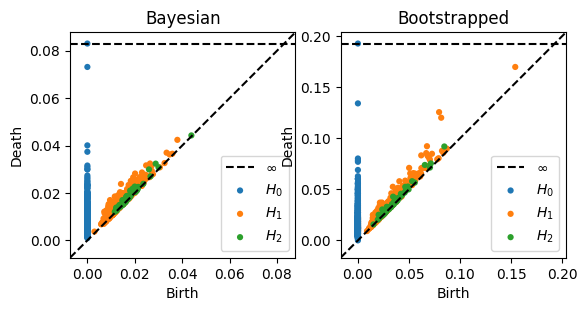

Bottleneck distance:
[0.061016328632831573, 0.02305416762828827, 0.004173662513494492]


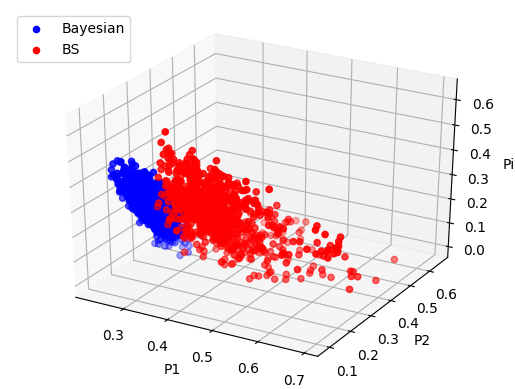

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.



 Bayesian model for yeast type 'Y130C':
Inference for Stan model: anon_model_8c8cef31884796c806a78281f651d649.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1       0.36  3.7e-4   0.01   0.33   0.35   0.36   0.37   0.39   1499    1.0
P2       0.16  6.5e-4   0.02   0.13   0.15   0.16   0.17    0.2    881    1.0
Pi        0.3  1.2e-3   0.04   0.22   0.28    0.3   0.33   0.37    956    1.0
sigma1   0.07  1.4e-4 5.3e-3   0.06   0.07   0.07   0.08   0.08   1522    1.0
lp__   223.93    0.06    1.6 219.71 223.17 224.33 225.14 225.88    723    1.0

Samples were drawn using NUTS at Sun Apr 28 13:24:51 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


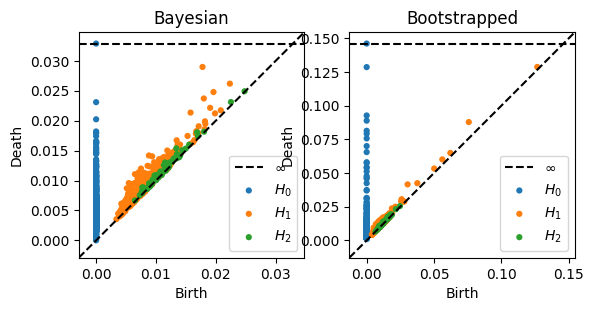

Bottleneck distance:
[0.06434750556945801, 0.006027486175298691, 0.0009595365263521671]


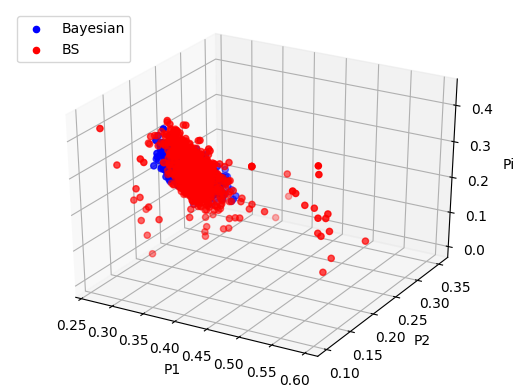

Bottleneck distance of Bayes PDs of WildType and Y130C:
[0.0365920253098011, 0.003430422395467758, 0.0019754646345973015]



In [0]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

y_type = ['WildType', 'Y130C', 'F53S', 'E203K']
persistence_ds = []

for i in range(len(y_type)):
  fit = stan_model_yd(bayes_td[i])
  
  print('\n Bayesian model for yeast type %r:' % y_type[i])
  print(fit)

  posterior = fit.extract()
  bayes_data = np.stack([posterior['P1'], posterior['P2'], posterior['Pi']])
  bayes_data = np.swapaxes(bayes_data, 0, 1)

  bayes_pd = ripser(bayes_data[0:800], maxdim = 2)
  persistence_ds.append(bayes_pd['dgms'])
  
  plt.title(y_type[i])
  plt.subplot(1, 2, 1)
  plot_diagrams(bayes_pd['dgms'], title='Bayesian')

  bs_pd = ripser(bs_data[i][0:800], maxdim = 2)
  
  plt.subplot(1, 2, 2)
  plot_diagrams(bs_pd['dgms'], title='Bootstrapped')
  plt.show()
  
  exp_file = '%s_PD.png' % y_type[i]
  #plt.savefig(exp_file)
  
  print('Bottleneck distance:')
  print(bottleneck_distance(bs_pd['dgms'], bayes_pd['dgms']))
  
  fig = plt.figure()
  
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(posterior['P1'], posterior['P2'], posterior['Pi'], c = 'b', marker='o', label='Bayesian')
  ax.scatter(bs_data[i][:, 0], bs_data[i][:, 1], bs_data[i][:, 2], c = 'r', marker='o', label='BS')
  ax.legend(loc='upper left')
  ax.set_xlabel('P1')
  ax.set_ylabel('P2')
  ax.set_zlabel('Pi')
  #ax.title(str(y_type[i]))

  plt.show()
  exp_file = '%s_Scatter.png' % y_type[i]
  #plt.savefig(exp_file)
  
for i in range(len(persistence_ds) - 1):
    for j in range(i + 1, len(persistence_ds)):
      print('Bottleneck distance of Bayes PDs of %s and %s:' % (y_type[i], y_type[j]))
      print(bottleneck_distance(persistence_ds[i], persistence_ds[j]))
      print('')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.


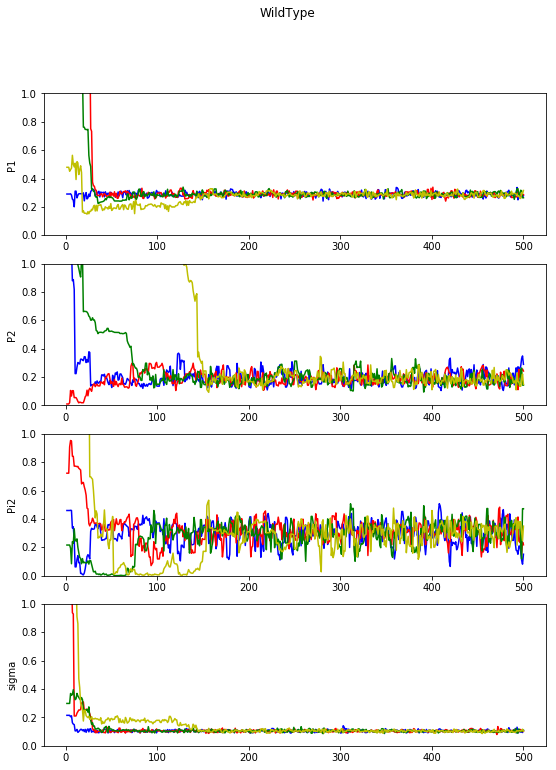

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.


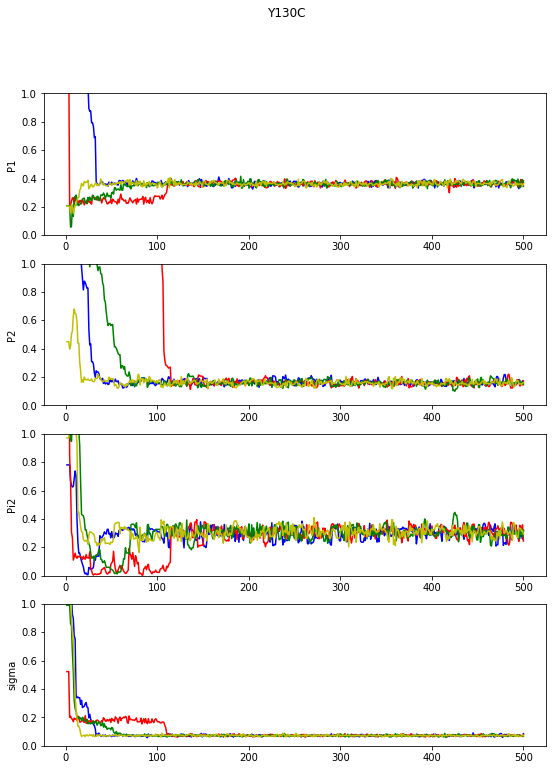

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c8cef31884796c806a78281f651d649 NOW.


In [0]:
#Plotting traces

y_type = ['WildType', 'Y130C', 'F53S', 'E203K']
y_label = ['P1', 'P2', 'Pi2', 'sigma']

for i in range(len(y_type)):
  fit = stan_model_yd(bayes_td[i])
  values = fit.extract(permuted = False, inc_warmup = True)
  
  x_vals = range(1, 501)
  
  plt.figure(figsize=(9,12))
  plt.suptitle(y_type[i])
  
  for j in range(4):
    plt.subplot(4, 1, j + 1)
    plt.plot(x_vals, values[0:500, 0, j], c='b')
    plt.plot(x_vals, values[0:500, 1, j], c='r')
    plt.plot(x_vals, values[0:500, 2, j], c='g')
    plt.plot(x_vals, values[0:500, 3, j], c='y')
  
    axes = plt.gca()
    axes.set_ylim([0,1])
    plt.ylabel(y_label[j])

    
  plt.show()



  

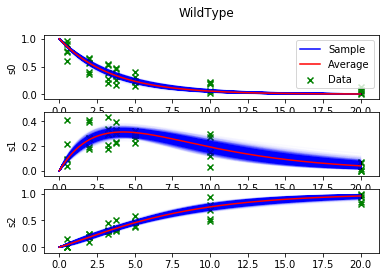

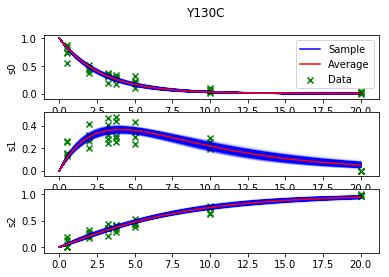

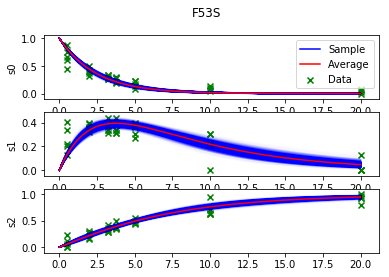

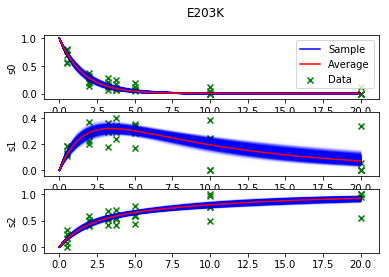

In [24]:
#Plots Bayesian model samples against empirical data

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

y_type = ['WildType', 'Y130C', 'F53S', 'E203K']
bayes_samples = []

for i in range(len(y_type)):
  fit = stan_model_yd(bayes_td[i])
  bayes_samples.append(fit.extract())
  
bayesian_params = [[0.29, 0.19, 0.3], [0.36, 0.16, 0.3], [0.41, 0.16, 0.28], [0.64, 0.1, 0.55]]
time_stamps = [0.5, 2, 3.25, 3.75, 5, 10, 20]
  
for i in range(4):
  scatter_x = [v for k in range(5) for v in time_stamps]
  scatter_y_s0 = [v/5 for k in range(5) for v in bayes_td[i, k, :, 0]]
  scatter_y_s1 = [v/5 for k in range(5) for v in bayes_td[i, k, :, 1]]
  scatter_y_s2 = [v/5 for k in range(5) for v in bayes_td[i, k, :, 2]]
  
  
  plot_x = np.arange(0, 20, 0.01)
  
  plt.suptitle(y_type[i])

  plt.subplot(3,1,1)
  for params in bayes_samples[i][:, :, 0:3]:
    for params1 in params:
      plt.plot(plot_x, s0_fun(plot_x, params1), c='b', alpha = 0.02)
      
  plt.plot(plot_x, s0_fun(plot_x, bayesian_params[i]), c='b', label='Sample')
  plt.plot(plot_x, s0_fun(plot_x, bayesian_params[i]), c='r', label='Average')
    
  plt.scatter(scatter_x, scatter_y_s0, c='g', marker='x', label='Data')
  plt.ylabel('s0')
  plt.legend(loc='upper right')

  
  plt.subplot(3,1,2)
  for params in bayes_samples[i][:, :, 0:3]:
    for params1 in params:
      plt.plot(plot_x, s1_fun(plot_x, params1), c='b', alpha = 0.02)
  
  plt.plot(plot_x, s1_fun(plot_x, bayesian_params[i]), c='b', label='Sample')
  plt.plot(plot_x, s1_fun(plot_x, bayesian_params[i]), c='r', label='Average')
    
  plt.scatter(scatter_x, scatter_y_s1, c='g', marker='x', label='Data')
  plt.ylabel('s1')

  plt.subplot(3,1,3)
  for params in bayes_samples[i][:, :, 0:3]:
    for params1 in params:
      plt.plot(plot_x, s2_fun(plot_x, params1), c='b', alpha = 0.02)
  
  plt.plot(plot_x, s2_fun(plot_x, bayesian_params[i]), c='b', label='Sample')
  plt.plot(plot_x, s2_fun(plot_x, bayesian_params[i]), c='r', label='Average') 
  
  plt.scatter(scatter_x, scatter_y_s2, c='g', marker='x', label='Data')
  plt.ylabel('s2')

  
  plt.show()

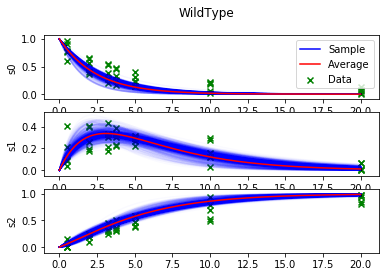

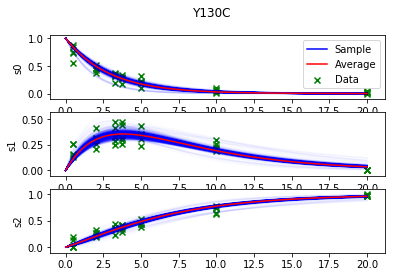

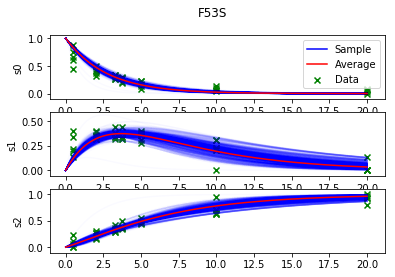

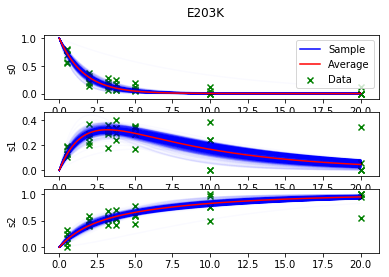

In [33]:
#Plots bootstrap model samples against empirical data

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

y_type = ['WildType', 'Y130C', 'F53S', 'E203K']
#bayes_samples = []

#for i in range(len(y_type)):
#  fit = stan_model_yd(bayes_td[i])
#  bayes_samples.append(fit.extract())
  
bs_params = [[0.41, 0.25, 0.27], [0.35, 0.19, 0.27], [0.37, 0.19, 0.25], [0.62, 0.13, 0.51]]
time_stamps = [0.5, 2, 3.25, 3.75, 5, 10, 20]
bs_samples = bs_data
  
for i in range(4):
  scatter_x = [v for k in range(5) for v in time_stamps]
  scatter_y_s0 = [v/5 for k in range(5) for v in bayes_td[i, k, :, 0]]
  scatter_y_s1 = [v/5 for k in range(5) for v in bayes_td[i, k, :, 1]]
  scatter_y_s2 = [v/5 for k in range(5) for v in bayes_td[i, k, :, 2]]
  
  
  plot_x = np.arange(0, 20, 0.01)
  
  #plt.figure(figsize=(8,10))
  plt.suptitle(y_type[i])

  plt.subplot(3,1,1)
  for params in bs_samples[i]:
    plt.plot(plot_x, s0_fun(plot_x, params), c='b', alpha = 0.02)
      
  plt.plot(plot_x, s0_fun(plot_x, bs_params[i]), c='b', label='Sample')
  plt.plot(plot_x, s0_fun(plot_x, bs_params[i]), c='r', label='Average')
    
  plt.scatter(scatter_x, scatter_y_s0, c='g', marker='x', label='Data')
  plt.ylabel('s0')
  plt.legend(loc='upper right')

  
  plt.subplot(3,1,2)
  for params in bs_samples[i]:
    plt.plot(plot_x, s1_fun(plot_x, params), c='b', alpha = 0.02)
  
  plt.plot(plot_x, s1_fun(plot_x, bs_params[i]), c='b', label='Sample')
  plt.plot(plot_x, s1_fun(plot_x, bs_params[i]), c='r', label='Average')
    
  plt.scatter(scatter_x, scatter_y_s1, c='g', marker='x', label='Data')
  plt.ylabel('s1')

  plt.subplot(3,1,3)
  for params in bs_samples[i]:
    plt.plot(plot_x, s2_fun(plot_x, params), c='b', alpha = 0.02)
  
  plt.plot(plot_x, s2_fun(plot_x, bs_params[i]), c='b', label='Sample')
  plt.plot(plot_x, s2_fun(plot_x, bs_params[i]), c='r', label='Average') 
  
  plt.scatter(scatter_x, scatter_y_s2, c='g', marker='x', label='Data')
  plt.ylabel('s2')

  
  plt.show()

In [9]:
#Plots Bayesian and BS average against data

time_stamps = [0.5, 2, 3.25, 3.75, 5, 10, 20]

bayesian_params = [[0.29, 0.19, 0.3], [0.36, 0.16, 0.3], [0.41, 0.16, 0.28], [0.64, 0.1, 0.55]]
bs_params = [[0.41, 0.25, 0.27], [0.35, 0.19, 0.27], [0.37, 0.19, 0.25], [0.62, 0.13, 0.51]]

y_type = ['Wild Type', 'Y130C', 'F53S', 'E203K']

for i in range(4):
  scatter_x = [v for k in range(5) for v in time_stamps]
  scatter_y_s0 = [v/5 for k in range(5) for v in bayes_td[i, k, :, 0]]
  scatter_y_s1 = [v/5 for k in range(5) for v in bayes_td[i, k, :, 1]]
  scatter_y_s2 = [v/5 for k in range(5) for v in bayes_td[i, k, :, 2]]
  
  
  plot_x = np.arange(0, 20, 0.01)
  
  plt.suptitle(y_type[i])

  plt.subplot(3,1,1)
  plt.plot(plot_x, s0_fun(plot_x, bayesian_params[i]), c='b', label='Bayesian')
  plt.plot(plot_x, s0_fun(plot_x, bs_params[i]), c='r', label='Bootstrap')
  plt.scatter(scatter_x, scatter_y_s0, c='g', marker='x', label='Data')
  plt.ylabel('s0')
  
  plt.subplot(3,1,2)
  plt.plot(plot_x, s1_fun(plot_x, bayesian_params[i]), c='b', label='Bayesian')
  plt.plot(plot_x, s1_fun(plot_x, bs_params[i]), c='r', label='Bootstrap')
  plt.scatter(scatter_x, scatter_y_s1, c='g', marker='x', label='Data')

  plt.subplot(3,1,3)
  plt.plot(plot_x, s2_fun(plot_x, bayesian_params[i]), c='b', label='Bayesian')
  plt.plot(plot_x, s2_fun(plot_x, bs_params[i]), c='r', label='Bootstrap')
  plt.scatter(scatter_x, scatter_y_s2, c='g', marker='x', label='Data')
  
  
  plt.show()
  

NameError: ignored